# Chapter 3 - Classification

## Importing MNIST Dataset

In [ ]:
# Fetch MNIST dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

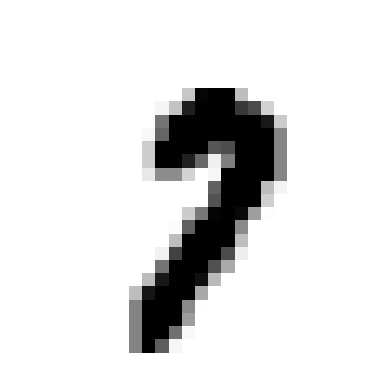

7


In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import randrange

d = randrange(len(X))

some_digit = X.iloc[d].values
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

print(y[d])

In [6]:
import numpy as np

y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier 

In [8]:
y_train_4 = (y_train == 4) # True for all 4s, False for all other digits.
y_test_4 = (y_test == 4)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 59)
sgd_clf.fit(X_train, y_train_4)

SGDClassifier(random_state=59)

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.97385, 0.9775 , 0.9765 ])

## Performance Measures

In [11]:
from sklearn.base import BaseEstimator

class Never4Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
nev4_clf = Never4Classifier()
cross_val_score(nev4_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.90275, 0.9018 , 0.90335])

### Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_4, y_train_pred)
# TN, FP
# FN, TP

array([[53572,   586],
       [  857,  4985]])

In [15]:
# Assuming we reached perfection
y_perfect_pred = y_train_4

print('A perfect confusion matrix would look like this:')
confusion_matrix(y_train_4, y_perfect_pred)

A perfect confusion matrix would look like this:


array([[54158,     0],
       [    0,  5842]])

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: ', precision_score(y_train_4, y_train_pred)) # TP / (TP + FP)
print('Recall: ', recall_score(y_train_4, y_train_pred)) # TP / (TP + FN)
print('F1: ', f1_score(y_train_4, y_train_pred)) # Harmonic mean of precision and recall

Precision:  0.8948124214683181
Recall:  0.8533036631290654
F1:  0.8735652326294576


In [29]:
# Let's check the decision function scores instead
y_some_score = sgd_clf.decision_function([some_digit])
threshold = -80000 # Default is 0
(y_some_score > threshold)

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([False])

### PR Curve

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3, method='decision_function')

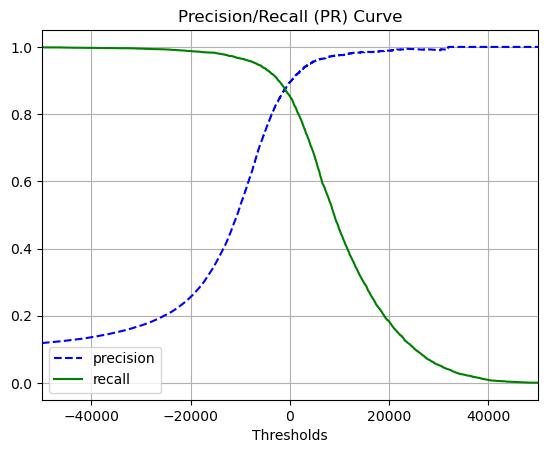

In [54]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_train_4, y_scores)

def plot_precision_vs_recall_vs_threshold(precisions, recalls, thresholds, x_start = -50000, x_end = 50000):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.legend()
    plt.xlim(x_start, x_end)
    plt.grid(True)
    plt.xlabel('Thresholds')
    plt.title('Precision/Recall (PR) Curve')
    plt.show()

plot_precision_vs_recall_vs_threshold(precisions, recalls, thresholds)

### ROC Curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


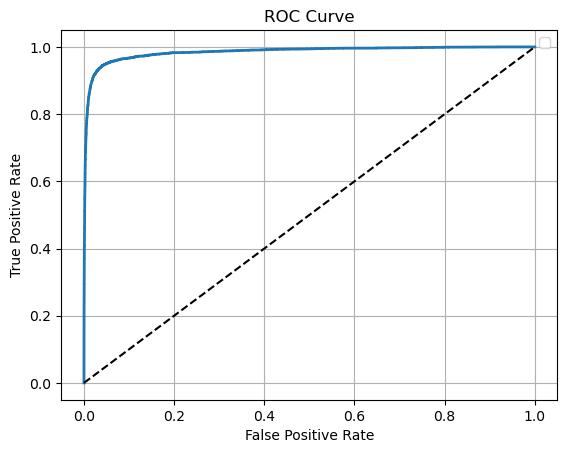

In [51]:
from sklearn.metrics import roc_curve

# False Positive Rate = Sensitivity = Recall
# True Positive Rate = 1 - specificity = Ratio of negative instances that incorrectly classified as positive
fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.legend()
    plt.grid(True)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

plot_roc_curve(fpr, tpr)

A good classifier stays as far away from that line as possible (toward
the top-left corner)

Therefore, one way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.

In [52]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_4, y_scores)

0.9850054474994672

<b>Notice:</b>
As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.

Let's use a RandomForestClassifier and compare the curves

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 22)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_4, cv=3, method='predict_proba')

In [62]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_4, y_scores_forest)

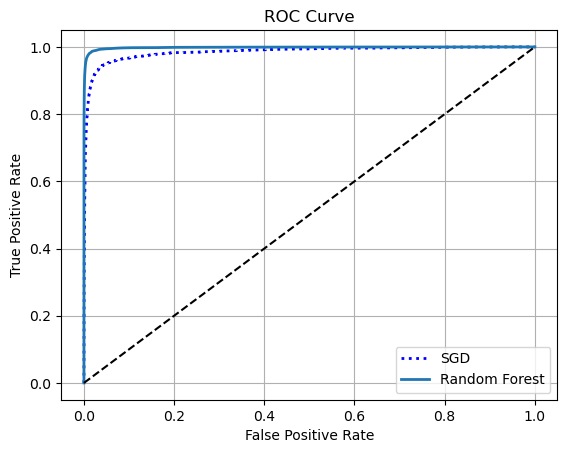

In [65]:
plt.plot(fpr, tpr, 'b:', linewidth=2, label='SGD')
plt.plot(fpr_forest, tpr_forest, linewidth=2, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.legend()
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [70]:
roc_auc_score(y_train_4, y_scores_forest)

0.9982713511516805

In [78]:
y_predictions_forest = cross_val_predict(forest_clf, X_train, y_train_4, cv=3)

In [79]:
# Let's try to measure the precision and recall for the random forest classifier
print('Precision:', precision_score(y_train_4, y_predictions_forest))
print('Recall:', recall_score(y_train_4, y_predictions_forest))
print('F1:', f1_score(y_train_4, y_predictions_forest))

Precision: 0.9903437620702974
Recall: 0.8777815816501198
F1: 0.9306715063520871


## Multiclass Classification

In [80]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([7], dtype=uint8)

In [82]:
# Scikit learn trained 10 binary classifiers under the hood
# By default, it automatically runs OvA strategy except for SVM classifier in which it uses OvO
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-19797.20389022, -24849.92592566, -14054.74478995,
         -6159.79872247, -19209.69026219, -13290.03572913,
        -22014.22802607,   9611.63393068,  -5206.04051877,
         -2449.14859851]])

In [85]:
# Let's use OvO strategy
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=12))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([7], dtype=uint8)

In [86]:
len(ovo_clf.estimators_)

45

In [87]:
# Random Forest Classifier can directly classify instances into multiple classes
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([7], dtype=uint8)

In [89]:
forest_clf.predict_proba([some_digit])

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.95, 0.  , 0.05]])

In [90]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8696 , 0.85725, 0.86465])

In [91]:
from sklearn.preprocessing import StandardScaler

# Let's try to scale the inputs as in chapter 3
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.89995, 0.8929 , 0.90105])

In [92]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [93]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5578,    0,   21,    6,    8,   46,   36,    6,  221,    1],
       [   0, 6402,   37,   25,    4,   44,    4,    7,  209,   10],
       [  28,   27, 5242,   91,   71,   26,   64,   39,  364,    6],
       [  21,   18,  119, 5237,    2,  205,   27,   39,  394,   69],
       [  12,   14,   48,   10, 5185,   11,   34,   25,  340,  163],
       [  26,   15,   30,  165,   55, 4461,   73,   16,  519,   61],
       [  28,   17,   43,    3,   44,   98, 5547,    5,  132,    1],
       [  19,   11,   53,   31,   48,   13,    3, 5695,  184,  208],
       [  17,   63,   48,   92,    3,  129,   24,   10, 5424,   41],
       [  24,   18,   30,   67,  118,   37,    1,  178,  369, 5107]])

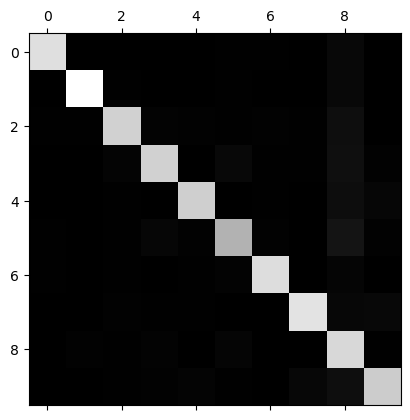

In [94]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [95]:
rows_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / rows_sums

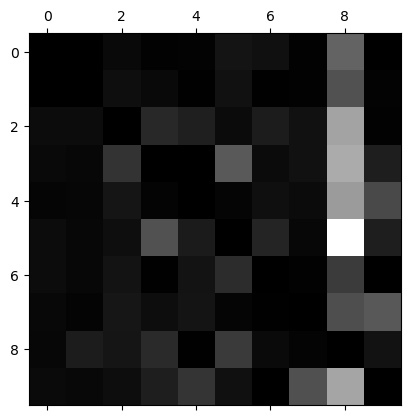

In [99]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

NameError: name 'plot_digits' is not defined

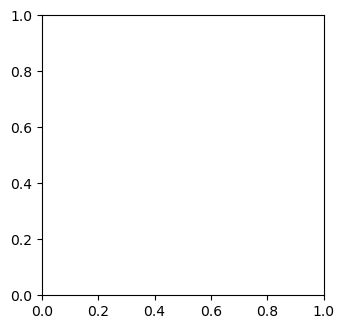

In [100]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Some of the digits that the classifier gets wrong re so badly written that even a human would have trouble classifying them.
However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did.
The reason is that we used a simple SGDClassifier, which is a linear model.
So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated.

## Multilabel Classification

In [102]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [103]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

In [104]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [107]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

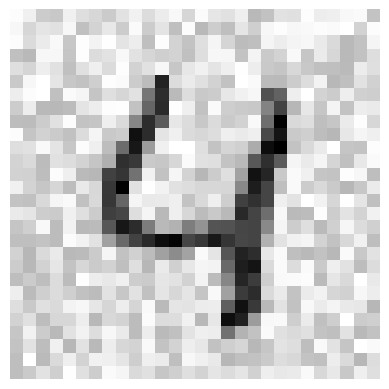

In [118]:
# Original
dirty_digit = X_test_mod.iloc[4].values.reshape(28,28)
plt.imshow(dirty_digit, cmap= mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


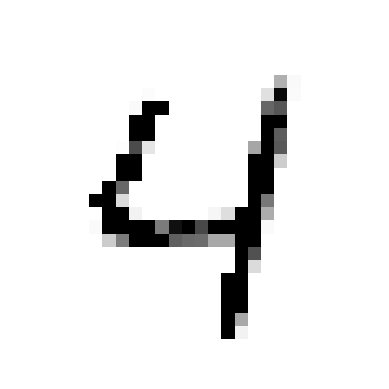

In [115]:
clean_digit = knn_clf.predict([X_test_mod.iloc[4]]).reshape(28, 28)
plt.imshow(clean_digit, cmap= mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()